In [64]:
import spotipy
import os
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
from collections import Counter
from wordcloud import WordCloud


In [65]:
load_dotenv()

True

In [66]:
# auth and token
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id = os.getenv('SPOTIFY_CLIENT_ID'),
    client_secret = os.getenv('SPOTIFY_CLIENT_SECRET'),
    redirect_uri='http://localhost:8000/callback',
    scope='user-top-read, playlist-read-private',
    #cache_path=cache_path
))

 long_term (calculated from ~1 year of data and including all new data as it becomes available), medium_term (approximately last 6 months), short_term (approximately last 4 weeks). Default: medium_term

## _clean dates fucntion_

In [67]:
# clean dates
# len() - str return int
# apply
def date_clean(date):
    if isinstance(date, str) and len(date) == 4 and date.isdigit():
        return int(date)
    elif isinstance(date, str):
        return pd.to_datetime(date, errors='coerce').year
    return date


# _get wiki function_

In [68]:
# get 'Genres' without slice or indices

def get_genres(artist_name):
    artist_name = artist_name.replace(" ", "_")

    url = f'https://en.wikipedia.org/wiki/{artist_name}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    table = soup.find("table", class_="infobox")
    if not table:
        return None
    
    for row in table.find_all('tr'):
        heading = row.find('th')

        if heading and 'Genres' in heading.text:
            data = row.find('td')
            genres = [li.text.strip() for li in data.find_all('li')]

            genres = [re.sub(r"\[\d+\]", "", genre) for genre in genres]

            if not genres:
                genres = data.text.strip().split(', ')

            return genres
    return None

pprint.pprint(get_genres('Frank Ocean'))

['Alternative R&B', 'psychedelic soul', 'avant-soul']


## _My Top Artists_

In [69]:
# get artists

def get_artists(time_range='long_term', limit=20):
    results = sp.current_user_top_artists(time_range=time_range, limit=limit)
    artists = []

    for item in results['items']:
        genres = item.get('genres')
        artists.append({
            'name': item['name'],
            'genres': ', '.join(item['genres']),
            'popularity': item['popularity'],
            'followers': item['followers']['total'],
        })
    df = pd.DataFrame(artists)

    # add other for empty genre lists
    df['Genres'] = df['genres'].apply(lambda x: x if x else 'other')

    return df



### _adding wiki scrape genres - func_

In [70]:
# create func to apply genres

#artists with other

def add_genres(df):
    for index, row in df[df['Genres'] == 'other'].iterrows():
        artist_name = row['name']

        new_genres = get_genres(artist_name)

        # got the list??
        if new_genres:
            df.at[index, 'Genres'] = ', '.join(new_genres)
        else:
            print(f'None found for {artist_name}')
    return new_genres

In [71]:
my_artists_df = get_artists('short_term')

# get medium and long taerm artists
my_artists_med = get_artists('medium_term')
my_artists_long = get_artists('long_term')

In [72]:
add_genres(my_artists_df)


None found for Adolphe Adam
None found for BICEP
None found for Agar Agar


In [73]:
add_genres(my_artists_long)


None found for Agar Agar
None found for Acid Arab


In [74]:
add_genres(my_artists_med)

None found for Adolphe Adam
None found for Agar Agar


In [75]:
all_top_artists = pd.concat([my_artists_df, my_artists_med, my_artists_long]).reset_index(drop=True).drop('genres', axis=1)

In [76]:
all_top_artists

,name,popularity,followers,Genres
0,Solange,61,2126290,"alternative r&b, neo soul"
1,Skunk Anansie,52,388347,"Alternative rock, hard rock, grunge, alternati..."
2,Azealia Banks,63,1118794,hip house
3,Mariah Carey,79,11131009,christmas
4,Nine Inch Nails,67,2823186,"industrial rock, industrial, industrial metal,..."
5,Frank Ocean,87,17848515,"Alternative R&B, psychedelic soul, avant-soul"
6,Adolphe Adam,45,8483,other
7,Lady Gaga,91,35195959,"art pop, pop"
8,The Internet,59,1479984,"alternative r&b, neo soul"
9,"Tyler, The Creator",90,20305343,"Alternative hip-hop, neo soul, West Coast hip ..."


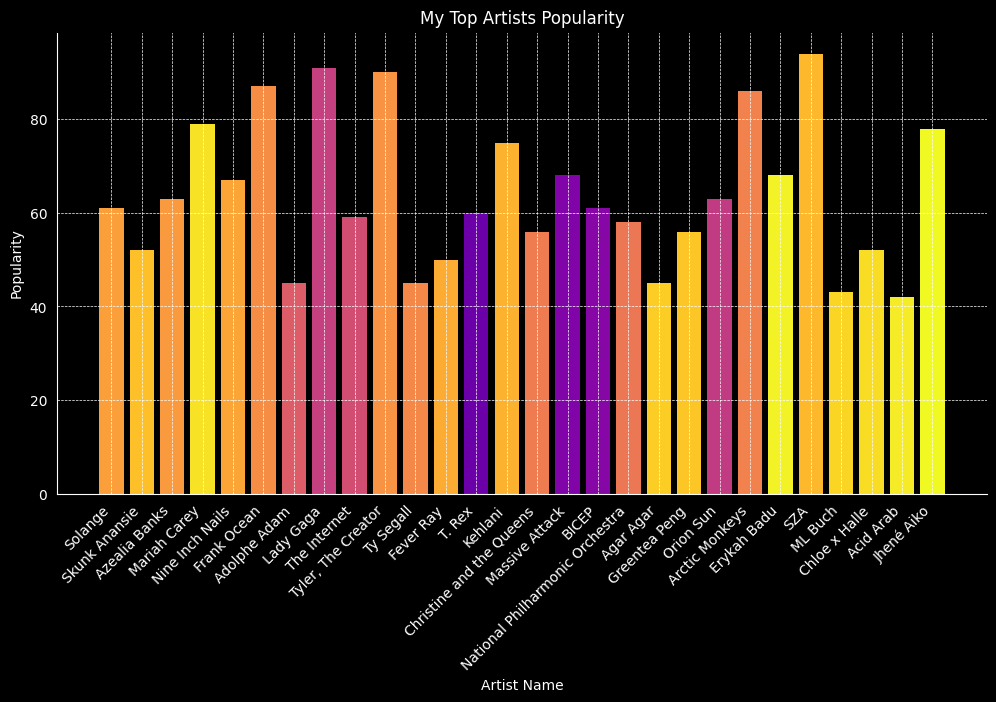

In [77]:
plt.figure(figsize=(12, 6), facecolor='black')
# plasma colormap
colors = plt.cm.plasma(np.linspace(0, 1, len(all_top_artists)))

plt.bar(all_top_artists['name'], all_top_artists['popularity'], color=colors)

ax = plt.gca()  

ax.set_facecolor("black")
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.title('My Top Artists Popularity', color='white')
plt.xlabel('Artist Name', color='white')  
plt.ylabel('Popularity', color='white')  

plt.xticks(rotation=45, ha='right', fontsize=10, color='white')  
plt.yticks(color='white')  

plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.show()

## _my top genres in top artists_

In [78]:

my_genres = [genre for sublist in all_top_artists['Genres'].str.split(', ') for genre in sublist]
genre_count = Counter(my_genres)
labels, sizes = zip(*genre_count.most_common(10))


C:\Users\AARON\AppData\Local\Temp\ipykernel_7424\4027634475.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)
C:\Users\AARON\AppData\Local\Temp\ipykernel_7424\4027634475.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)
C:\Users\AARON\AppData\Local\Temp\ipykernel_7424\4027634475.py:5: UserWarning: The palette list has more values (60) than needed (46), which may not be intended.
  sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)


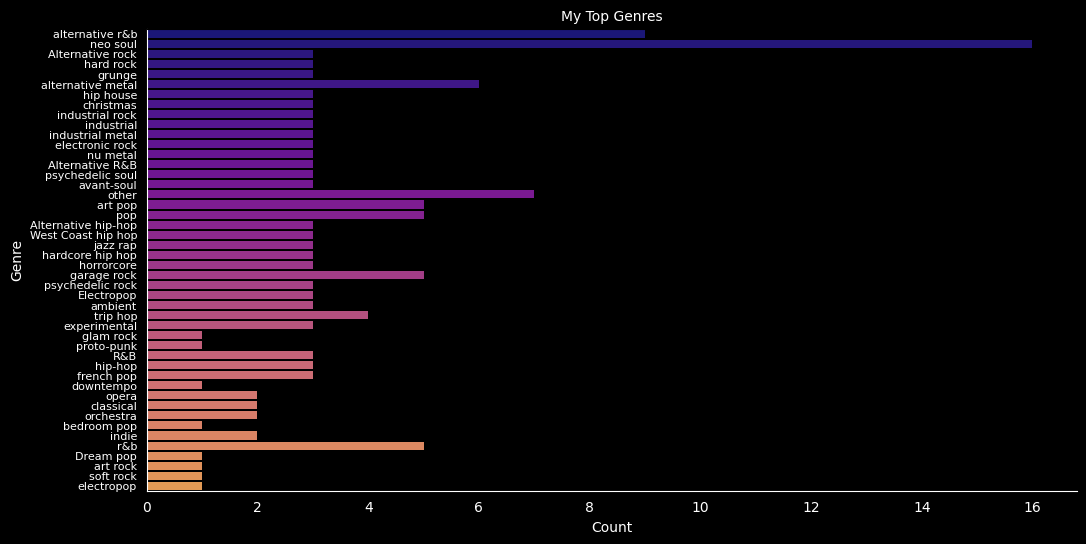

In [79]:

plt.figure(figsize=(12,6), facecolor='black')
# plasma colormap
colors = plt.cm.plasma(np.linspace(0, 1, len(all_top_artists)))

sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)

ax = plt.gca()  
ax.set_facecolor("black")
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.xlabel("Count", color='white')
plt.ylabel("Genre", color='white')
plt.title('My Top Genres', fontsize=10, color='white')

plt.yticks(fontsize=8, color='white')  
plt.xticks(color='white')  

plt.show()


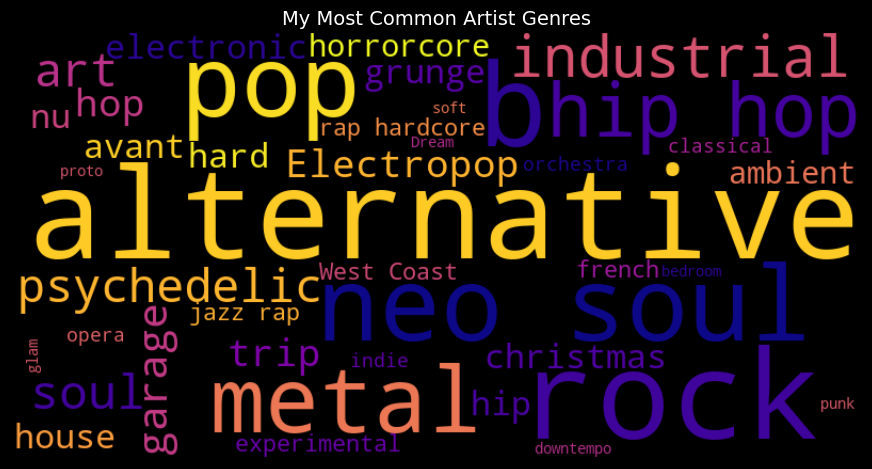

In [80]:
# Combine all genres into a single string
all_genres = ' '.join(all_top_artists['Genres'].dropna())  

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(all_genres)

# Plot the word cloud
plt.figure(figsize=(11, 18), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("My Most Common Artist Genres", fontsize=14, color='white')
plt.show()

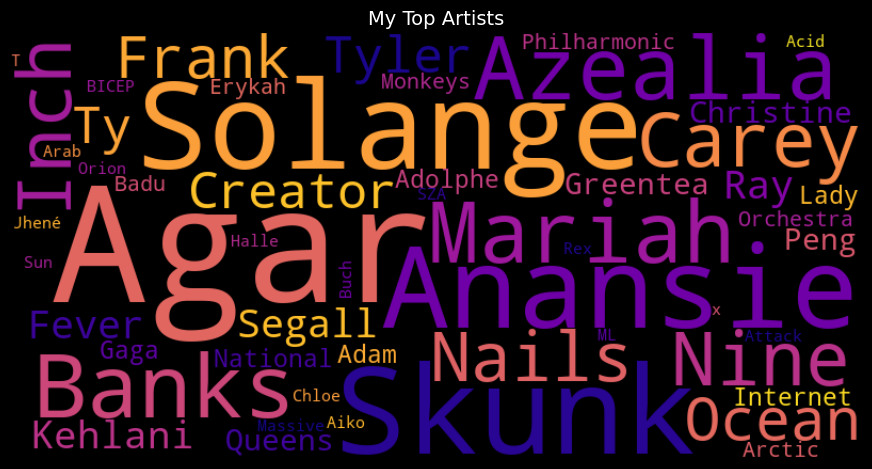

In [81]:
# Combine all genres into a single string
all_artist_names = ' '.join(all_top_artists['name'].dropna())  

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(all_artist_names)

# Plot the word cloud
plt.figure(figsize=(11, 18), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("My Top Artists", fontsize=14, color='white')
plt.show()

## top tracks from top artists

In [82]:
#my_artists_df['name']

In [83]:
def tracks_from_artists(all_top_artists, time_range='medium_term', limit=50):
    results = sp.current_user_top_tracks(time_range=time_range,  limit=limit)
    tracks = []
    
    # print raw
    
    #print("Raw top tracks fetched:")
    #for item in results['items']:
    #    print(item['name'], "by", [artist['name'] for artist in item['artists']])
    
    #grab top artist names
    top_artist_names = set(all_top_artists['name'])
    
    for item in results['items']:
        artist_per_track = [artist['name'] for artist in item['artists']]

        if any(artist in top_artist_names for artist in artist_per_track):
            tracks.append({
                'track name': item['name'],
                'artists': ', '.join(artist_per_track),
                'album': item['album']['name'],
                'release': item['album']['release_date'],
                'track id': item['id'],
                'popularity': item['popularity']
            })
            
    tracks_df = pd.DataFrame(tracks)
    return tracks_df

In [84]:
my_top_tracks_from_top_artists_df = tracks_from_artists(all_top_artists)
my_top_tracks_from_top_artists_df['release'] = my_top_tracks_from_top_artists_df['release'].apply(date_clean)
my_top_tracks_from_top_artists_df.head()


,track name,artists,album,release,track id,popularity
0,Die With A Smile,"Lady Gaga, Bruno Mars",Die With A Smile,2024,2plbrEY59IikOBgBGLjaoe,97
1,Brazen (Weep),Skunk Anansie,Stoosh,1996,1mSVdpc7uHEXYfKVtHd1su,40
2,Charlie Big Potato,Skunk Anansie,Post Orgasmic Chill,1999,7FY6MkxmeSt6WSeC0XnY5m,42
3,Pink + White,Frank Ocean,Blonde,2016,3xKsf9qdS1CyvXSMEid6g8,83
4,Big eye,Christine and the Queens,"PARANOÏA, ANGELS, TRUE LOVE",2023,0fGbCVPP41cReDwIAuOORJ,20


# top tracks

In [85]:
# get top tracks

def get_tracks(time_range='short_term', limit=50):
    results = sp.current_user_top_tracks(time_range=time_range, limit=limit)
    t_tracks = []

    for item in results['items']:
        track_artists = [artist['name'] for artist in item['artists']]
        t_tracks.append({
            'track name': item['name'],
            'artists': ', '.join(track_artists),
            'album': item['album']['name'],
            'release': item['album']['release_date'],
            'duration ms': item['duration_ms'],
            'track id': item['id'],
            'popularity': item['popularity']
        })
    top_tracks_df = pd.DataFrame(t_tracks)
    top_tracks_df['release'].apply(date_clean)
    
    return top_tracks_df

In [86]:
my_tracks_df = get_tracks('short_term')

my_tracks_med_df = get_tracks('medium_term')

my_tracks_long_df = get_tracks('long_term')


### merge all time frames - long_term (calculated from ~1 year of data and including all new data as it becomes available), medium_term (approximately last 6 months), short_term (approximately last 4 weeks). Default: medium_term

In [87]:
all_top_tracks = pd.concat([my_tracks_df, my_tracks_med_df, my_tracks_long_df]).reset_index(drop=True).drop_duplicates(subset=['track id'])

In [88]:

all_top_tracks['release'] = all_top_tracks['release'].apply(date_clean)


In [89]:
# cobvert duration to secs
all_top_tracks['duration ms'] = all_top_tracks['duration ms'] // 1000
# add duration in mins and secs
all_top_tracks['duration mm:ss'] = all_top_tracks['duration ms'].apply(lambda x: f'{int(x // 60):02}:{int(x % 60):02}')

In [90]:
all_top_tracks.rename(columns={'duration ms': 'duration secs'}, inplace=True)

In [91]:
all_top_tracks.head()

,track name,artists,album,release,duration secs,track id,popularity,duration mm:ss
0,Shake It Off,Mariah Carey,The Emancipation of Mimi,2005,232,6rJQTvhKl5GSEA8SWW7t1X,54,03:52
1,Silencer,Dub War,Wrong Side Of Beautiful,1996,312,1premcRnMNh9KvM7WWtgz5,12,05:12
2,Brazen (Weep),Skunk Anansie,Stoosh,1996,271,1mSVdpc7uHEXYfKVtHd1su,40,04:31
3,Black Jesus + Amen Fashion,Lady Gaga,Born This Way (Special Edition),2011,216,3u8L4te13sTuqyHNR7j2rB,35,03:36
4,Get Away,The Internet,Ego Death,2015,148,10SUWedx0zohs8M3OJpnA7,47,02:28


### _scatter plot for track duraation_

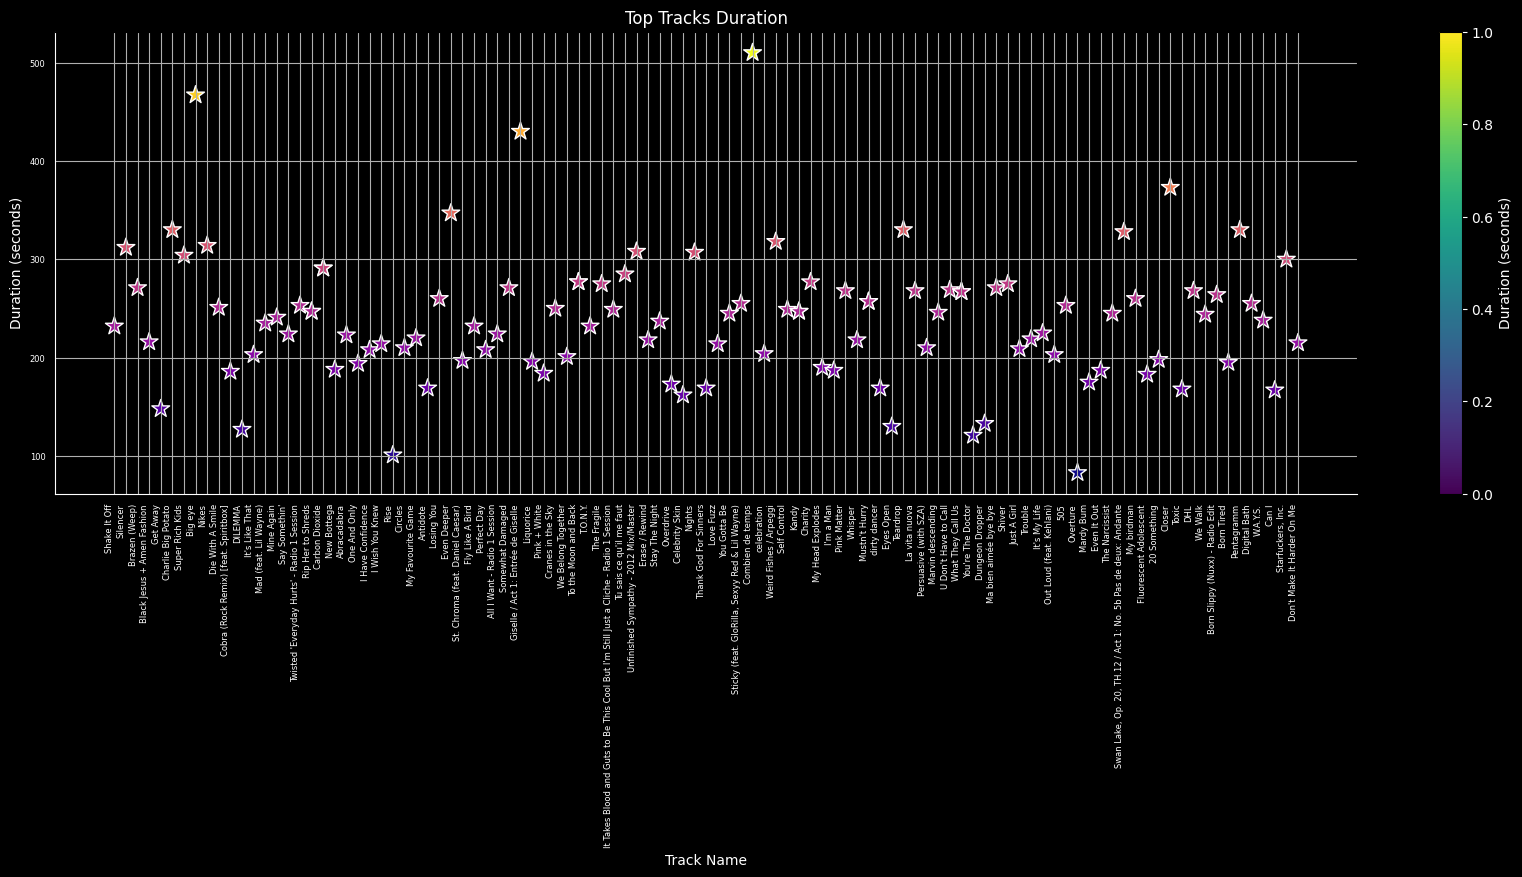

In [92]:
plt.figure(figsize=(21, 6), facecolor='black')
plt.gca().set_facecolor('black') 

norm = plt.Normalize(all_top_tracks['duration secs'].min(), all_top_tracks['duration secs'].max())
colors = plt.cm.plasma(norm(all_top_tracks['duration secs']))

scatter = plt.scatter(all_top_tracks['track name'], all_top_tracks['duration secs'], color=colors, edgecolors='white', s=180, marker='*') 
plt.xlabel('Track Name', color='white')
plt.ylabel('Duration (seconds)', color='white')
plt.title('Top Tracks Duration', color='white')
plt.xticks(rotation=90, ha='right', fontsize='6', color='white')
plt.yticks(fontsize='6', color='white')

#xy lines
ax = plt.gca()  #grab axis
ax.spines['left'].set_color('white') 
ax.spines['bottom'].set_color('white')

#colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Duration (seconds)', color='white') 
cbar.ax.yaxis.set_tick_params(color='white') 
cbar.ax.yaxis.set_tick_params(labelcolor='white')

plt.grid(True)
plt.show()

### _looking for the percentage of tracks per decade_

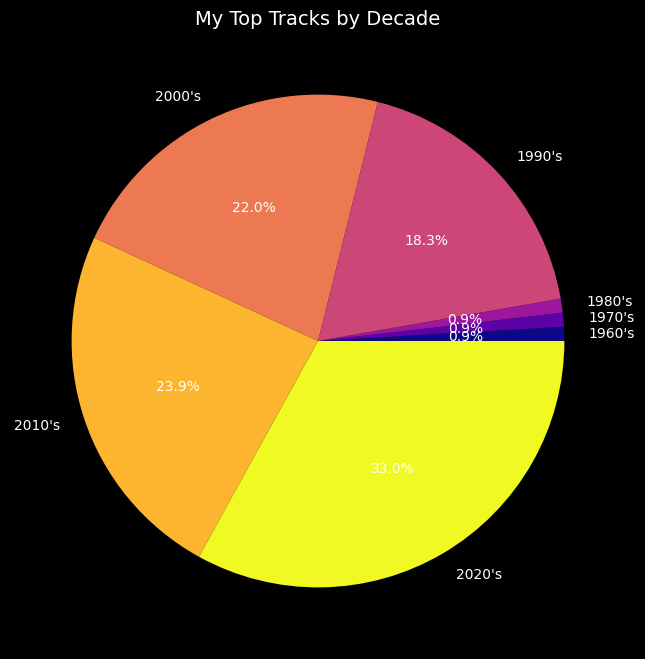

In [93]:
# get decades
all_top_tracks['decade'] = (all_top_tracks['release'] // 10 * 10).astype(str) + "'s"

#count
decade_counts = all_top_tracks['decade'].value_counts().sort_index()

colors = plt.cm.plasma(np.linspace(0, 1, len(decade_counts)))

plt.figure(figsize=(8, 8), facecolor='black')
plt.pie(decade_counts, labels=decade_counts.index, autopct='%1.1f%%', colors=colors, textprops={'color': 'white'})


plt.title('My Top Tracks by Decade', fontsize=14, color='white')

plt.show()

# playlists

### get all

In [94]:
def get_playlists():
    results = sp.current_user_playlists()
    all_playlists = []

    while results:
        for playlist in results['items']:
            all_playlists.append({
                "playlist_name": playlist["name"],
                "total_tracks": playlist["tracks"]["total"],
                "playlist_id": playlist["id"]
            })
        # pagination
        if results["next"]:
            results = sp.next(results)
        else:
            break
    
    all_playlists = pd.DataFrame(all_playlists)
    return all_playlists


In [95]:
my_playlists = get_playlists()
my_playlists.head()

,playlist_name,total_tracks,playlist_id
0,Gaga in order,25,1VK03kdKyRNc86QkdqFmj9
1,?,1,2Jla4LLDdGndqCKxP7ZeIo
2,mmmm,21,0a68WVAAQcjjlddZGijvOG
3,❤️‍🔥🎧🫠🎧❤️‍🔥,7,0qv3HLAftJbN8Z8glhiCs7
4,Hmmm,12,13km7JNQUh5DRGV9QexgpI


In [96]:
def get_playlist_tracks(my_playlists, limit=50):
    playlist_tracks = []

    for playlist_id, playlist_name in zip(my_playlists['playlist_id'], my_playlists['playlist_name']): #zip loops through the iterations???
        results = sp.playlist_tracks(playlist_id, limit=limit)  # Get tracks from the playlist

        for item in results['items']:
            track = item.get('track') 
            
            if track:  # 
                playlist_tracks.append({
                    'track_name': track['name'],
                    'artists': ', '.join([artist['name'] for artist in track['artists']]),
                    'album': track['album']['name'],
                    'release_year': track['album']['release_date'],
                    'playlist name': playlist_name,
                    'track_id': track['id'],
                    'playlist_id': playlist_id,
                    'popularity': track['popularity']
                })
    

    tracks_df = pd.DataFrame(playlist_tracks)

    return tracks_df

In [97]:

my_tracks_from_playlists = get_playlist_tracks(my_playlists)

#my_tracks_from_playlists.drop_duplicates(subset=['track_id'], keep='first', inplace=True) # modified for finding most listened playlists - duplicated dropped for create_playlist.py

my_tracks_from_playlists['release_year'] = my_tracks_from_playlists['release_year'].apply(date_clean)

my_tracks_from_playlists.rename(columns={'track_name': 'track name', 'release_year': 'release year', 'track_id': 'track id', 'playlist_id': 'playlist id'}, inplace=True)

In [98]:
my_tracks_from_playlists

,track name,artists,album,release year,playlist name,track id,playlist id,popularity
0,Speechless,Lady Gaga,The Fame Monster (UK Deluxe),2009,Gaga in order,36ebL42b6QAqitgzbkIjw5,1VK03kdKyRNc86QkdqFmj9,34
1,The Edge Of Glory,Lady Gaga,Born This Way (International Special Edition V...,2011,Gaga in order,57F80059mWaWFvWG3tBTbO,1VK03kdKyRNc86QkdqFmj9,66
2,Hey Girl,"Lady Gaga, Florence Welch",Joanne (Deluxe),2016,Gaga in order,554PnB96IltLzVlbinBstw,1VK03kdKyRNc86QkdqFmj9,50
3,Alejandro,Lady Gaga,The Fame Monster (UK Deluxe),2009,Gaga in order,0iOu4s8w3pE9vbpb1SHXsL,1VK03kdKyRNc86QkdqFmj9,54
4,Telephone,"Lady Gaga, Beyoncé",The Fame Monster (UK Deluxe),2009,Gaga in order,6nCDnzErqalOaIY3EJM8NK,1VK03kdKyRNc86QkdqFmj9,59
...,...,...,...,...,...,...,...,...
851,Mr. Sun (miss da sun),Greentea Peng,RISING,2019,Greentea Peng Complete Playlist,5E7uh0dIynOaedLv7Aoush,4Ez43npblDHbzx0lCz0jwU,17
852,Sane,Greentea Peng,RISING,2019,Greentea Peng Complete Playlist,3RkdLBGzG6PIgf10eZyqzj,4Ez43npblDHbzx0lCz0jwU,30
853,Liberation,Greentea Peng,RISING,2019,Greentea Peng Complete Playlist,7x0vFyfEmCHNGFAgnELBnf,4Ez43npblDHbzx0lCz0jwU,28
854,Downers,Greentea Peng,Downers,2019,Greentea Peng Complete Playlist,1fnU60yGjhsP1QY335rH2m,4Ez43npblDHbzx0lCz0jwU,48


## convert to csv for creat_paylist script

In [99]:
my_tracks_from_playlists.to_csv('my_playlist_tracks.csv')

# * _which albums occur across top tracks and playlists?_

* albums [] - if album in all_top_tracks and album in my_tracks_from_playlists: albums.append(aalbum, artist) - print albums ???


In [100]:
#iitterrows

# use set to remove duplicates - for now i only want to see a list - so, list(set(albums))??

In [101]:
albums = []

#loop through all tracks
for index1, row1 in all_top_tracks.iterrows():
    album1 = row1['album']
    artist1 = row1['artists']

    artist1 = artist1.split(',')[0] 
        
    if album1 in my_tracks_from_playlists['album'].values:
        albums.append((album1, artist1))

albums = list(set(albums))

pprint.pprint(albums)

[("It Was Good Until It Wasn't", 'Kehlani'),
 ('Ungodly Hour', 'Chloe x Halle'),
 ('We Started Nothing', 'The Ting Tings'),
 ('Mean Girls (Original Motion Picture Soundtrack)', 'Boomkat'),
 ('PARANOÏA, ANGELS, TRUE LOVE', 'Christine and the Queens'),
 ('Player Non Player', 'Agar Agar'),
 ('Chilombo', 'Jhené Aiko'),
 ('A Seat at the Table', 'Solange'),
 ('Perfect Day Single', 'Hoku'),
 ('White Pony', 'Deftones'),
 ('Plunge', 'Fever Ray'),
 ('In Rainbows', 'Radiohead'),
 ('The Ballad of Darren', 'Blur'),
 ('Goodbye Bread', 'Ty Segall'),
 ('Broken Hearts Club', 'Syd'),
 ('The Fragile', 'Nine Inch Nails'),
 ('Souled Out (Deluxe)', 'Jhené Aiko'),
 ('Radical Romantics', 'Fever Ray'),
 ('La vita nuova', 'Christine and the Queens'),
 ('1991 - EP', 'Azealia Banks'),
 ('8701', 'USHER'),
 ("Whatever People Say I Am, That's What I'm Not", 'Arctic Monkeys'),
 ('Blonde', 'Frank Ocean'),
 ('The Singles Collection', 'No Doubt'),
 ('Favourite Worst Nightmare', 'Arctic Monkeys'),
 ('Cobra (Rock Remix) [

### _add playlist id to mytracksfromplaylists to determine which playlist tracks are pulled from_ 
    * _need to bring back duplicates_
    

In [102]:
matches = all_top_tracks[all_top_tracks['track id'].isin(my_tracks_from_playlists['track id'])]['track name'].tolist()
pprint.pprint(matches)

['Silencer',
 'Super Rich Kids',
 'Big eye',
 'Cobra (Rock Remix) [feat. Spiritbox]',
 'Mad (feat. Lil Wayne)',
 'Antidote',
 'Perfect Day',
 'Pink + White',
 'Cranes in the Sky',
 'The Fragile',
 'Celebrity Skin',
 'You Gotta Be',
 'Combien de temps',
 'Weird Fishes / Arpeggi',
 'Self Control',
 'My Head Explodes',
 'La vita nuova',
 "U Don't Have to Call",
 'Shiver',
 'Just A Girl',
 'Trouble',
 "It's My Life",
 "Mustn't Hurry",
 'Out Loud (feat. Kehlani)',
 '505',
 'Mardy Bum',
 'Rip Her to Shreds',
 'The Narcissist',
 'To the Moon and Back',
 'Swan Lake, Op. 20, TH.12 / Act 1: No. 5b Pas de deux: Andante',
 'Fluorescent Adolescent',
 '20 Something',
 'Toxic',
 'We Walk',
 'Born Slippy (Nuxx) - Radio Edit',
 'Born Tired',
 'Digital Bath',
 'W.A.Y.S.',
 'Can I',
 'Starfuckers, Inc.',
 "Don't Make It Harder On Me"]


In [103]:
track_playlist_matches = all_top_tracks[all_top_tracks['track id'].isin(my_tracks_from_playlists['track id'])].merge(my_tracks_from_playlists[['track id','playlist name', 'playlist id']], on='track id', how='left')

track_playlist_matches.drop(columns=['popularity', 'album', 'release'], axis=1)


,track name,artists,duration secs,track id,duration mm:ss,decade,playlist name,playlist id
0,Silencer,Dub War,312,1premcRnMNh9KvM7WWtgz5,05:12,1990's,the dailies,3kjzy5R1zPdnid2TYUQd2j
1,Super Rich Kids,"Frank Ocean, Earl Sweatshirt",304,0725YWm6Z0TpZ6wrNk64Eb,05:04,2010's,the dailies,3kjzy5R1zPdnid2TYUQd2j
2,Big eye,Christine and the Queens,467,0fGbCVPP41cReDwIAuOORJ,07:47,2020's,Hmmm,13km7JNQUh5DRGV9QexgpI
3,Big eye,Christine and the Queens,467,0fGbCVPP41cReDwIAuOORJ,07:47,2020's,the dailies,3kjzy5R1zPdnid2TYUQd2j
4,Cobra (Rock Remix) [feat. Spiritbox],"Megan Thee Stallion, Spiritbox",186,6HNWDjbome8TQp0rYRZTQS,03:06,2020's,the dailies,3kjzy5R1zPdnid2TYUQd2j
...,...,...,...,...,...,...,...,...
58,Digital Bath,Deftones,255,2jSJm3Gv6GLxduWLenmjKS,04:15,2000's,Chill,4NHOoP5BGZbYrWohyaJJDW
59,W.A.Y.S.,Jhené Aiko,238,7jjKsW39O1i8hKF31ShpV9,03:58,2010's,Chill,4NHOoP5BGZbYrWohyaJJDW
60,Can I,Kehlani,167,0uDdI4fAXCuNhQbmxENdsO,02:47,2020's,Chill,4NHOoP5BGZbYrWohyaJJDW
61,"Starfuckers, Inc.",Nine Inch Nails,300,5RxKqRKJva5ZcVa0ltdxuX,05:00,1990's,the dailies,3kjzy5R1zPdnid2TYUQd2j


### _count amount of top tracks per playlist_

In [104]:
top_playlists = track_playlist_matches['playlist name'].value_counts()

top_playlists = top_playlists[top_playlists > 2]

top_playlists

playlist name
the dailies       22
Chill             15
Movie              8
Hmmm               6
My playlist #7     4
Name: count, dtype: int64

* _great. this was the expected output. i mostly listen to those top 2 playlists else, song radios._
* _next, plot_

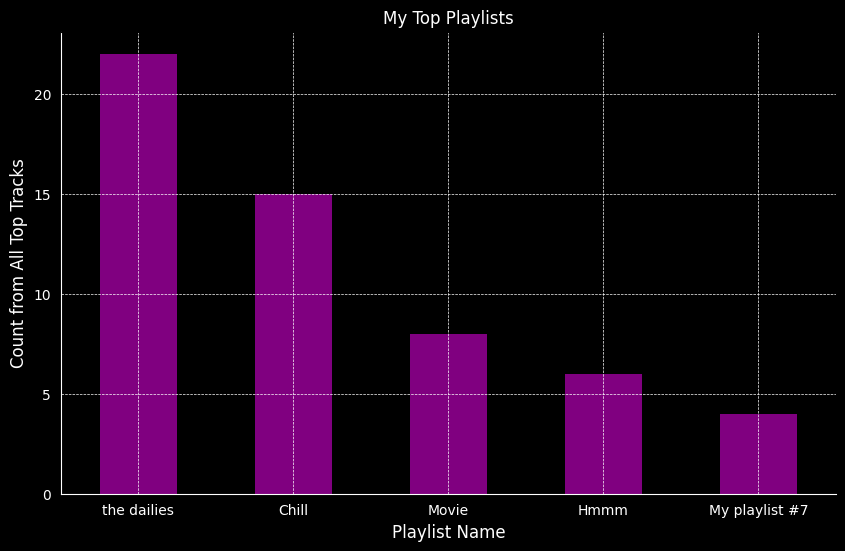

In [105]:
# my most listened to playlists from all_top_tracks count

plt.figure(figsize=(10, 6), facecolor='black')
top_playlists.plot(kind='bar', color='purple')

ax = plt.gca()  

ax.set_facecolor("black")
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.title('My Top Playlists', color='white')
plt.xlabel('Playlist Name', fontsize=12, color='white')
plt.ylabel('Count from All Top Tracks', fontsize=12, color='white')

plt.xticks(rotation=0, ha='center', fontsize=10, color='white')
plt.yticks(fontsize=10, color='white')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.show()